![](https://bonitasprings.floridaweekly.com/wp-content/uploads/images/2017-11-09/15p1.jpg)

In [1]:
from __future__ import print_function, division
import os
import cv2
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
plt.ion()  
import seaborn as sns
import shutil
import warnings
warnings.filterwarnings('ignore')
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
else:
    print("Using CPU")

Using CUDA


In [2]:
data = pd.read_csv('../input/brain-tumor/Brain Tumor.csv', usecols=[0,1])
os.mkdir("all_data")
os.mkdir("all_data/Tumor")
os.mkdir("all_data/non-Tumor")

In [3]:
data[data["Image"]=="Image150"]

,Image,Class
149,Image150,1


torch.Size([3, 240, 240])
Image150
Image label is  1


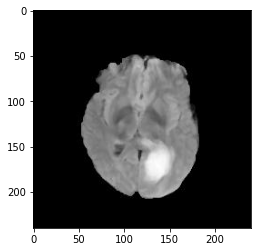

In [4]:
#Take a look to a sampler Image
example_image = '../input/brain-tumor/Brain Tumor/Brain Tumor/Image150.jpg'

img150 = torchvision.io.read_image(example_image) 
                                                
print(img150.shape)
import matplotlib.pyplot as plt
plt.imshow(img150.permute((1,2,0)))
print(data.loc[149][0])
print("Image label is ", data.loc[149][1])

# For more information about Transfer Learning, you can check-up the [notebook](https://www.kaggle.com/code/zzettrkalpakbal/transfer-learning-vgg16-medical-mnist-100) I published earlier.

In [5]:
path = '../input/brain-tumor/Brain Tumor/Brain Tumor/'
for i in range(data.shape[0]):
    a = data["Image"].iloc[i]
    if data["Class"].iloc[i] == 0:
        shutil.copy2(path+str(a+".jpg"), "/kaggle/working/all_data/non-Tumor")
    else:
        shutil.copy2(path+str(a+".jpg"), "/kaggle/working/all_data/Tumor")

In [6]:
print("Target = 0 files number in new folder; ",len(os.listdir("/kaggle/working/all_data/non-Tumor")))
print("Target = 1 files number in new folder; ",len(os.listdir("/kaggle/working/all_data/Tumor")))
dfvc = data.Class.value_counts()
print(f"Target = 0 files number in dataset; {dfvc.values[0]}")
print(f"Target = 1 files number in dataset; {dfvc.values[1]}")


Target = 0 files number in new folder;  2079
Target = 1 files number in new folder;  1683
Target = 0 files number in dataset; 2079
Target = 1 files number in dataset; 1683


In [7]:
path= "/kaggle/working/all_data"
targets=os.listdir(path)
print(targets)

['Tumor', 'non-Tumor']


In [8]:
data_dir= "/kaggle/working/all_data/splitted_data"
train_path=os.path.join(data_dir,'train')
valid_path=os.path.join(data_dir,'valid')
test_path=os.path.join(data_dir,'test')

In [9]:
def make_dir():
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)
        os.mkdir(train_path)
        os.mkdir(valid_path)
        os.mkdir(test_path)
        for target in targets:
            os.mkdir(os.path.join(train_path,target))
            os.mkdir(os.path.join(valid_path,target))
            os.mkdir(os.path.join(test_path,target))
def check_dir():
    print(f'{data_dir}: {os.path.isdir(data_dir)}')
    print(f'{train_path}: {os.path.isdir(train_path)}')
    print(f'{valid_path}: {os.path.isdir(valid_path)}')
    print(f'{test_path}: {os.path.isdir(test_path)}')
    for target in targets:
        print(f'{os.path.join(train_path,target)}: {os.path.isdir(os.path.join(train_path,target))}')
        print(f'{os.path.join(valid_path,target)}: {os.path.isdir(os.path.join(valid_path,target))}')
        print(f'{os.path.join(test_path,target)}: {os.path.isdir(os.path.join(test_path,target))}')

make_dir()
check_dir()

/kaggle/working/all_data/splitted_data: True
/kaggle/working/all_data/splitted_data/train: True
/kaggle/working/all_data/splitted_data/valid: True
/kaggle/working/all_data/splitted_data/test: True
/kaggle/working/all_data/splitted_data/train/Tumor: True
/kaggle/working/all_data/splitted_data/valid/Tumor: True
/kaggle/working/all_data/splitted_data/test/Tumor: True
/kaggle/working/all_data/splitted_data/train/non-Tumor: True
/kaggle/working/all_data/splitted_data/valid/non-Tumor: True
/kaggle/working/all_data/splitted_data/test/non-Tumor: True


In [10]:
# Properties of images;
import cv2
image = cv2.imread('/kaggle/working/all_data/non-Tumor/Image594.jpg')
print(f'Image size: {image.shape}')
print(f'Max pixel value: {np.max(image)}')


Image size: (240, 240, 3)
Max pixel value: 255


### Actually, there are more patients in the non-Tumor group, but since I want a fully balanced set, I will only include them in the non-Tumor group as much as the Tumor group.

In [11]:
# train:test:valid = 1178:336:169 = 70:20:10
def load_train_images(path=path,n=1178):
    for target in targets:
        data_path=os.path.join(path,target)
        dest=os.path.join(train_path,target)
        image_set=random.sample(os.listdir(data_path),n)
        print(f'Loading the training images for {target}')
        for file in tqdm(image_set):
            file_path=os.path.join(data_path,file)
            shutil.copy(file_path,dest)
def load_valid_images(path=path,n=169):
    for target in targets:
        data_path=os.path.join(path,target)
        dest=os.path.join(valid_path,target)
        image_set=random.sample(os.listdir(data_path),n)
        print(f'Loading the validation images for {target}')
        for file in tqdm(image_set):
            file_path=os.path.join(data_path,file)
            shutil.copy(file_path,dest)
def load_test_images(path=path,n=336):
    for target in targets:
        data_path=os.path.join(path,target)
        dest=os.path.join(test_path,target)
        image_set=random.sample(os.listdir(data_path),n)
        print(f'Loading the testing images for {target}')
        for file in tqdm(image_set):
            file_path=os.path.join(data_path,file)
            shutil.copy(file_path,dest)
    
import random
from tqdm import tqdm
import shutil
load_train_images()
load_valid_images()
load_test_images()

Loading the training images for Tumor


100%|██████████| 1178/1178 [00:00<00:00, 10208.51it/s]


Loading the training images for non-Tumor


100%|██████████| 1178/1178 [00:00<00:00, 10328.55it/s]


Loading the validation images for Tumor


100%|██████████| 169/169 [00:00<00:00, 9787.46it/s]


Loading the validation images for non-Tumor


100%|██████████| 169/169 [00:00<00:00, 10004.90it/s]


Loading the testing images for Tumor


100%|██████████| 336/336 [00:00<00:00, 10045.23it/s]


Loading the testing images for non-Tumor


100%|██████████| 336/336 [00:00<00:00, 10587.38it/s]


In [12]:
data_dir = './all_data/splitted_data'
TRAIN = 'train'
VAL = 'valid'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.6),
        transforms.RandomRotation(degrees=10),               
        transforms.RandomResizedCrop(240),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], # Gaussian Noise
                             [0.229, 0.224, 0.225])
    ]),
    VAL: transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], # Gaussian Noise
                             [0.229, 0.224, 0.225])
    ]),
    TEST: transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], # Gaussian Noise
                             [0.229, 0.224, 0.225])
   ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 2356 images under train
Loaded 338 images under valid
Loaded 672 images under test
Classes: 
['Tumor', 'non-Tumor']


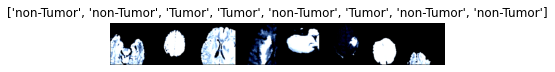

In [13]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [14]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [15]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [16]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [17]:
mod = list(vgg.classifier.children())
mod.pop()
mod.append(torch.nn.Linear(4096, 2))# Input Layer and output
new_classifier = torch.nn.Sequential(*mod)
vgg.classifier = new_classifier
vgg = vgg.to(device)
criterion = torch.nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 each epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.1)
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
print("Test before training")
eval_model(vgg,criterion)

Test before training
Evaluating model
----------
Test batch 0/84
Evaluation completed in 0m 12s
Avg loss (test): 0.0868
Avg acc (test): 0.5134
----------


In [19]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=16):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        vgg.train(True)
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)   
            # Use half training dataset
            if i >= train_batches / 2:
                break  
            inputs, labels = data
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            outputs = vgg(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]
        vgg.train(False)
        vgg.eval()
        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
            inputs, labels = data
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            optimizer.zero_grad()
            outputs = vgg(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    vgg.load_state_dict(best_model_wts)
    return vgg

In [20]:
vgg = train_model(vgg, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=16)

Epoch 0/16
----------
Training batch 100/147.5
Validation batch 0/43
Epoch 0 result: 
Avg loss (train): 0.0581
Avg acc (train): 0.8022
Avg loss (val): 0.0367
Avg acc (val): 0.8994
----------

Epoch 1/16
----------
Training batch 100/147.5
Validation batch 0/43
Epoch 1 result: 
Avg loss (train): 0.0360
Avg acc (train): 0.8888
Avg loss (val): 0.0227
Avg acc (val): 0.9408
----------

Epoch 2/16
----------
Training batch 100/147.5
Validation batch 0/43
Epoch 2 result: 
Avg loss (train): 0.0322
Avg acc (train): 0.9049
Avg loss (val): 0.0275
Avg acc (val): 0.9231
----------

Epoch 3/16
----------
Training batch 100/147.5
Validation batch 0/43
Epoch 3 result: 
Avg loss (train): 0.0243
Avg acc (train): 0.9338
Avg loss (val): 0.0133
Avg acc (val): 0.9704
----------

Epoch 4/16
----------
Training batch 100/147.5
Validation batch 0/43
Epoch 4 result: 
Avg loss (train): 0.0219
Avg acc (train): 0.9414
Avg loss (val): 0.0243
Avg acc (val): 0.9260
----------

Epoch 5/16
----------
Training batch 100

In [21]:
print("Test after training")
eval_model(vgg,criterion)

Test after training
Evaluating model
----------
Test batch 0/84
Evaluation completed in 0m 3s
Avg loss (test): 0.0073
Avg acc (test): 0.9821
----------


Ground truth:


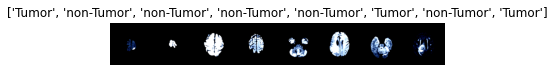

Prediction:


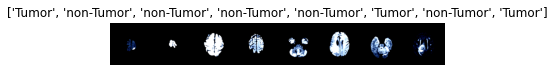

Ground truth:


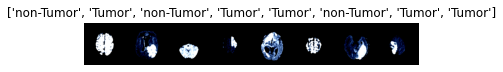

Prediction:


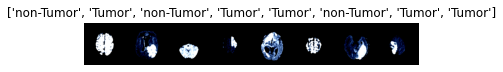

In [22]:
visualize_model(vgg, num_images=16) #test before training